# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [41]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using Plots
    using NoisyReach
    using Distributions
    using Experiment
    using QuadGK
    using ControlSystemsBase
    using LinearAlgebra
    using ReachabilityAnalysis
end

  Activating project at `~/NoisyReach.jl`


## 2. Validation for Integral function

In [61]:
const Ts = 0.01
const Dc = 0.005 # 
sys = benchmarks[:F1]

StateSpace{ControlSystemsBase.Continuous, Float64}
A = 
 0.0  6.5
 0.0  0.0
B = 
  0.0
 19.68503937007874
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model

In [62]:
sys_aug_ = let
    ϕ = ℯ^(Ts * sys.A)
    Γ₁ = matrix_integral(sys.A, sys.B, Dc, Ts)
    Γ₀ = matrix_integral(sys.A, sys.B, 0.0, Ts - Dc)
    ϕ_aug = [ϕ Γ₁; 0 0 0]
    Γ_aug = [Γ₀; I]
    C_aug = [sys.C 0]
    ss(ϕ_aug, Γ_aug, C_aug, sys.D, Ts)
end

StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.065  0.004798228346456693
 0.0  1.0    0.0984251968503937
 0.0  0.0    0.0
B = 
 0.0015994094488188976
 0.0984251968503937
 1.0
C = 
 1.0  0.0  0.0
D = 
 0.0

Sample Time: 0.01 (seconds)
Discrete-time state-space model

In [63]:
#sys_aug = c2d(sys, Ts) * delay(Dc, Ts)
sys_aug = c2d(sys, Ts) * thiran(Dc, Ts)

StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.065   0.0056867891513560824
 0.0  1.0     0.17497812773403326
 0.0  0.0    -0.3333333333333333
B = 
 0.002132545931758531
 0.06561679790026248
 1.0
C = 
 1.0  0.0  0.0
D = 
 0.0

Sample Time: 0.01 (seconds)
Discrete-time state-space model

## 3. Physical System and Neural Networks Uncertainty Setup

In [66]:
sys = benchmarks[:F1]
const period = 0.02
const Dc1 = 0.005
const Dc2 = 0.015

0.015

In [67]:
sys_aug = let
    ϕ = ℯ^(period * sys.A)
    Γ2 = matrix_integral(sys.A, sys.B, Dc2, period)
    Γ1 = matrix_integral(sys.A, sys.B, Dc1, Dc2)
    Γ3 = matrix_integral(sys.A, sys.B, 0.0, Dc1)
    ϕ_aug = [ϕ Γ3; 0 0 0]
    Γ_aug = [Γ1 Γ2; 0 I]
    C_aug = [sys.C 0]
    D_aug = [sys.D 0]
    ss(ϕ_aug, Γ_aug, C_aug, D_aug, Ts)
end
K = lqr(ControlSystemsBase.Discrete, sys_aug.A, sys_aug.B, I, I)

2×3 Matrix{Float64}:
 0.723651  1.09385  0.0995609
 0.307036  0.48328  0.0441294

In [68]:
σ1 = 0.3
σ2 = 0.2
μ = 0.
H = 10
x0 = 1.
u1_0 = 0.
u2_0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u2_0]

3-element Vector{Float64}:
 1.0
 1.0
 0.0

## 4. Calculate and Plot Reachable Trajectories

In [69]:
all_trajectories=[]
number = 10000
for i in 1:number
    z = evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0, σ1, σ2, μ)
    push!(all_trajectories, z)
end
z_ideal = ideal_evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0)

11-element Vector{Vector{Float64}}:
 [1.0, 1.0, 0.0]
 [1.13, 1.0, 0.0]
 [1.2937543264162197, 1.4580106805845743, 0.8302298037075365]
 [1.5308134745732787, 2.1662974910632786, 1.138492956927537]
 [1.8777435017858937, 3.1394421462185584, 1.5671825983478944]
 [2.375916532685916, 4.480781558266129, 2.1629212548102505]
 [3.0828262307835854, 6.333667974674987, 2.9904096880002378]
 [4.078331934607113, 8.89698461562367, 4.139434923155236]
 [5.473323816652915, 12.446675990535816, 5.734595072439753]
 [7.421747587530668, 17.365624594808644, 7.948794160778147]
 [10.137291102745401, 24.185109608311446, 11.02196845495594]

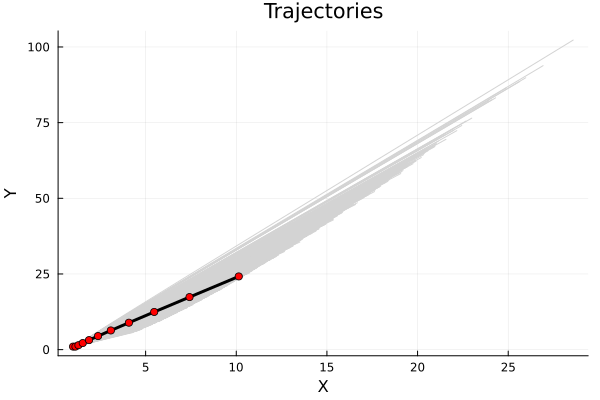

In [70]:
traj_plot = plot(title="Trajectories", xlabel="X", ylabel="Y")
for trajectory in all_trajectories
    x = [point[1] for point in trajectory]
    y = [point[2] for point in trajectory]
    
    plot!(x, y,  label="", linecolor=:lightgray, linewidth=1)
end
x_z = [point[1] for point in z_ideal]
y_z = [point[2] for point in z_ideal]
plot!(x_z, y_z, marker=:circle, label="", linecolor=:black, linewidth=3,  markercolor=:red, markersize=4)
display(traj_plot)